In [25]:
import numpy as np

In [23]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading the dataset and tokenizer
emotions_dataset = load_dataset('emotion')
training_data = emotions_dataset['train']
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize the dataset
def tokenize_dataset(batch_data):
    return tokenizer(batch_data['text'], padding=True, truncation=True)
emotions_tokenized = emotions_dataset.map(tokenize_dataset, batched=True)

# Model
distilbert = AutoModel.from_pretrained('distilbert-base-uncased').to(device)
emotions_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Extracting last hidden state from the model
def extract_hidden_state(batch):
    inputs = {k: batch[k].to(device) for k in ['input_ids', 'attention_mask']}
    with torch.no_grad():
        outputs = distilbert(**inputs)
        last_hidden_state = outputs.last_hidden_state[:, 0].cpu().numpy()
    return {"hidden_state": last_hidden_state}

# Extract the hidden state of the whole dataset
emotions_hidden_state = emotions_tokenized.map(extract_hidden_state, batched=True, batch_size=1000)

# Check the column names to confirm if the operation was successful
print(emotions_hidden_state['train'].column_names)


Map: 100%|██████████| 2000/2000 [01:47<00:00, 18.59 examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']


In [24]:
print(emotions_hidden_state['train']['hidden_state'].shape)

torch.Size([16000, 768])


In [26]:
X_train = np.array(emotions_hidden_state["train"]["hidden_state"])
X_valid = np.array(emotions_hidden_state["validation"]["hidden_state"])
y_train = np.array(emotions_hidden_state["train"]["label"])
y_valid = np.array(emotions_hidden_state["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [30]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
     

LogisticRegression(max_iter=3000)

In [31]:

lr_clf.score(X_valid, y_valid)

0.6335

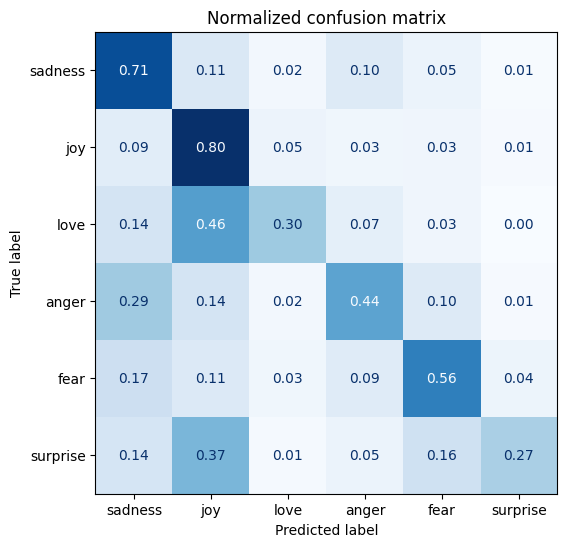

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
labels = emotions_dataset["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)